In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score, classification_report,roc_curve, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

---
# Import and Preprocess Yahoo S&P 500 Health Care Sector Data

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from collections import deque 

In [3]:
SPHC = yf.download('^SP500-35', start='2019-11-01', end='2021-12-31')

[*********************100%***********************]  1 of 1 completed


In [4]:
SPHC.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-11-01,1099.069946,1106.729980,1097.310059,1097.410034,1097.410034,176457500
2019-11-04,1100.790039,1102.439941,1093.579956,1093.619995,1093.619995,168564900
2019-11-05,1095.199951,1095.640015,1083.829956,1083.839966,1083.839966,204060200
2019-11-06,1085.130005,1092.020020,1084.150024,1089.910034,1089.910034,194907900
2019-11-07,1093.510010,1095.160034,1088.650024,1091.459961,1091.459961,181873900


In [5]:
SPHC.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 545 entries, 2019-11-01 to 2021-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       545 non-null    float64
 1   High       545 non-null    float64
 2   Low        545 non-null    float64
 3   Close      545 non-null    float64
 4   Adj Close  545 non-null    float64
 5   Volume     545 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 29.8 KB


In [6]:
# Preprocess Data

# Store Date and Change Index
SPHC["Date"] = SPHC.index
index = pd.Index(range(0, len(SPHC)))
SPHC = SPHC.set_index(index)

# Diff
SPHC['Diff'] = SPHC['High'] - SPHC['Low']

# Diff20
Diff20 = [None for i in range(19)]
Diff20sum = 0

# DiffChange
DiffChange = [None for i in range(20)]

# Return
Return = [None]

# Return5
Return5 = [None for i in range(5)]

# MA10
MA10 = [None for i in range(9)]
MA10sum = 0

# MA30
MA30 = [None for i in range(29)]
MA30sum = 0

# MA100
MA100 = [None for i in range(99)]
MA100sum = 0

# MA10-30
MA1030 = [None for i in range(29)]

# MA30-100
MA30100 = [None for i in range(99)]

# High30
High30 = [None for i in range(29)]
High30q = deque()

# Low30
Low30 = [None for i in range(29)]
Low30q = deque()

# Break30
Break30 = [None for i in range(30)]

# Vol20
Vol20 = [None for i in range(20)]
Vol20q = deque()

# Label
Label = [None for i in range(99)]

for i in range(len(SPHC)):
    curr = SPHC.loc[i]["Adj Close"]
    
    # Diff20
    Diff20sum+=SPHC.loc[i]['Diff']
    if i>19:
        Diff20sum-=SPHC.loc[i-20]['Diff']
    if i>18:
        Diff20.append(Diff20sum/20)
    
    # DiffChange:
    if i>19:
        if SPHC.loc[i]['Diff']>Diff20[i-1]:
            DiffChange.append(1)
        elif SPHC.loc[i]['Diff']==Diff20[i-1]:
            DiffChange.append(0)
        else:
            DiffChange.append(-1)
    
    # Return
    if i>0:
        prev = SPHC.loc[i-1]["Adj Close"]
        Return.append((curr - prev)/prev*100)
    
    # Return5
    if i>4:
        prev5 = SPHC.loc[i-5]["Adj Close"]
        Return5.append((curr - prev5)/prev5*100)
    
    # MA10
    MA10sum+=curr
    if i>9:
        MA10sum-=SPHC.loc[i-10]['Adj Close']
    if i>8:
        MA10.append(MA10sum/10)
    
    # MA30
    MA30sum+=curr
    if i>29:
        MA30sum-=SPHC.loc[i-30]['Adj Close']
    if i>28:
        MA30.append(MA30sum/30)
    
    # MA100
    MA100sum+=curr
    if i>99:
        MA100sum-=SPHC.loc[i-100]['Adj Close']
    if i>98:
        MA100.append(MA100sum/100)
    
    # MA10-30
    if i>28:
        if MA10[i]>MA30[i]:
            MA1030.append(1)
        elif MA10[i]==MA30[i]:
            MA1030.append(0)
        else:
            MA1030.append(-1)
    
    # MA30-100
    if i>98:
        if MA30[i]>MA100[i]:
            MA30100.append(1)
        elif MA30[i]==MA100[i]:
            MA30100.append(0)
        else:
            MA30100.append(-1)
    
    # High30
    while High30q and curr>High30q[-1]:
        High30q.pop()
    High30q.append(curr)
    if i>29 and High30q[0] == SPHC.loc[i-30]['Adj Close']:
        High30q.popleft()
    if i>28:
        High30.append(High30q[0])
    
    # Low30
    while Low30q and curr<Low30q[-1]:
        Low30q.pop()
    Low30q.append(curr)
    if i>29 and Low30q[0] == SPHC.loc[i-30]['Adj Close']:
        Low30q.popleft()
    if i>28:
        Low30.append(Low30q[0])
    
    # Break 30
    if i>=30:
        if curr>High30[i-1]:
            Break30.append(1)
        elif curr<Low30[i-1]:
            Break30.append(-1)
        else:
            Break30.append(0)
    
    # Vol20
    if i>0:
        Vol20q.append(Return[i])
    if len(Vol20q)>20:
        Vol20q.popleft()
    if i>19:
        Vol20.append(np.std(Vol20q))

# Label
for i in range(99, len(SPHC)-1):
    if Return[i+1]>0:
        Label.append(1)
    elif Return[i+1]==0:
        Label.append(0)
    else:
        Label.append(-1)
Label.append(None)
            
        
SPHC["Diff20"] = Diff20
SPHC["DiffChange"] = DiffChange
SPHC["Return"] = Return
SPHC["Return5"] = Return5
SPHC["MA10"] = MA10
SPHC["MA30"] = MA30
SPHC["MA100"] = MA100
SPHC["MA1030"] = MA1030
SPHC["MA30100"] = MA30100
SPHC["High30"] = High30
SPHC["Low30"] = Low30
SPHC["Break30"] = Break30
SPHC["Vol20"] = Vol20
SPHC["Label"] = Label

In [7]:
SPHC.head(11)

,Open,High,Low,Close,Adj Close,Volume,Date,Diff,Diff20,DiffChange,...,MA10,MA30,MA100,MA1030,MA30100,High30,Low30,Break30,Vol20,Label
0,1099.069946,1106.729980,1097.310059,1097.410034,1097.410034,176457500,2019-11-01,9.419922,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1100.790039,1102.439941,1093.579956,1093.619995,1093.619995,168564900,2019-11-04,8.859985,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1095.199951,1095.640015,1083.829956,1083.839966,1083.839966,204060200,2019-11-05,11.810059,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1085.130005,1092.020020,1084.150024,1089.910034,1089.910034,194907900,2019-11-06,7.869995,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1093.510010,1095.160034,1088.650024,1091.459961,1091.459961,181873900,2019-11-07,6.510010,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1090.979980,1100.189941,1089.969971,1100.180054,1100.180054,161431000,2019-11-08,10.219971,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1095.349976,1097.910034,1092.449951,1095.630005,1095.630005,123120400,2019-11-11,5.460083,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1095.810059,1105.660034,1095.750000,1101.979980,1101.979980,147179200,2019-11-12,9.910034,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1099.369995,1105.760010,1097.459961,1103.189941,1103.189941,157290900,2019-11-13,8.300049,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1102.869995,1104.189941,1096.359985,1102.380005,1102.380005,148511500,2019-11-14,7.829956,NaN,NaN,...,1095.959998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Drop None Rows
SPHC.drop([len(SPHC)-1], inplace = True)
SPHC.drop([i for i in range(99)], inplace = True)

# Select features
SPHC = SPHC[["Date","High","Low","Volume","Diff","DiffChange","Return","Return5","MA1030","MA30100","Break30","Vol20","Label"]]

# Reset Index
index = pd.Index(range(0, len(SPHC)))
SPHC = SPHC.set_index(index)
SPHC = SPHC.astype({'Label':'int'})

In [9]:
SPHC

,Date,High,Low,Volume,Diff,DiffChange,Return,Return5,MA1030,MA30100,Break30,Vol20,Label
0,2020-03-26,1017.919983,956.090027,330854600,61.829956,1.0,6.980419,6.241499,-1.0,-1.0,0.0,5.154044,-1
1,2020-03-27,1016.599976,983.049988,268403500,33.549988,-1.0,-2.412379,8.084310,-1.0,-1.0,0.0,5.170170,1
2,2020-03-30,1038.810059,1007.289978,295893000,31.520081,-1.0,4.672499,19.057623,-1.0,-1.0,0.0,5.162704,-1
3,2020-03-31,1043.520020,1022.320007,319522200,21.200012,-1.0,-0.393446,10.225382,-1.0,-1.0,0.0,5.136844,-1
4,2020-04-01,1007.309998,984.010010,236572800,23.299988,-1.0,-3.860974,4.645185,-1.0,-1.0,0.0,5.003834,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,2021-12-22,1620.040039,1597.160034,206269700,22.880005,1.0,1.169801,0.849031,1.0,1.0,1.0,0.834586,1
441,2021-12-23,1630.839966,1618.630005,156471400,12.209961,-1.0,0.406424,0.676927,1.0,1.0,1.0,0.832564,1
442,2021-12-27,1642.790039,1625.880005,134065500,16.910034,-1.0,1.047019,2.421822,1.0,1.0,1.0,0.831860,-1
443,2021-12-28,1647.219971,1634.489990,131304400,12.729980,-1.0,-0.281263,2.786836,1.0,1.0,0.0,0.842883,1


---
# Machine Learning Models

## Split the Data into the Train and Test set

In [10]:
data = SPHC
list_features = list(data)
list_features.remove('Date')
list_features.remove('Label')
x = data[list_features]
y = data['Label']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30, random_state=7)

## Improve the Decision Tree Model

In [11]:
#Improve the Decision Tree Model
#Using grid search, the parameters of max_depth and min_samples_split are adjusted in a small range
param_grid = {
    'max_depth':np.arange(2, 6),
    'min_samples_split':np.arange(2, 18)}

rfc = DecisionTreeClassifier(random_state=10)
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(x_train,y_train)
dt = [GS.best_params_['max_depth'],GS.best_params_['min_samples_split']]
print(GS.best_params_)
print(GS.best_score_)

{'max_depth': 2, 'min_samples_split': 2}
0.5240927419354838


## Improve the Random Forest Model

In [12]:
#Improve the Random Forest  Model
#Using grid search, the parameters of max_depth and min_samples_split are adjusted in a small range
param_grid = {
    'max_depth':np.arange(2, 6),
    'min_samples_split':np.arange(2, 10)}

rfc = RandomForestClassifier(random_state=10)
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(x_train,y_train)
rf = [GS.best_params_['max_depth'],GS.best_params_['min_samples_split']]
print(GS.best_params_)
print(GS.best_score_)

{'max_depth': 4, 'min_samples_split': 6}
0.5431451612903226


## Improve the Logistic Regression Model

In [13]:
#Improve the Logistic Regression Model
#Using grid search, the parameter of max_iter is adjusted in a small range
param_grid = {
    'max_iter':np.arange(300, 2000,100)}

rfc = LogisticRegression(solver='lbfgs')
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(x_train,y_train)
lg = GS.best_params_['max_iter']
print(GS.best_params_)
print(GS.best_score_)

{'max_iter': 300}
0.553024193548387


## Improve the LightGBM Model

In [14]:
#Improve the Decision Tree Model
#Using grid search, the parameters of max_depth and min_samples_split are adjusted in a small range
param_grid = {
    'max_depth':np.arange(2, 6),
    'num_leaves':np.arange(2, 18)}

rfc = LGBMClassifier(random_state=10)
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(x_train,y_train)
lgb = [GS.best_params_['max_depth'],GS.best_params_['num_leaves']]
print(GS.best_params_)
print(GS.best_score_)

{'max_depth': 2, 'num_leaves': 4}
0.5334677419354839


## Compare Models

In [15]:
#We implement a class of methods to call all previous steps into one unique cell.
class classi:
    def __init__(self,estimators):
        self.algo=estimators
        self.best_estimateurs={}
     #Fitting the models before the prediction phase
    
    #Prediction used on the test set for all our models
    def pred(self,x_train,y_train,x_test,y_test):
        pred={}
        for estim in self.algo:
            self.algo[estim]['mod'].fit(x_train,y_train)
            pred[estim]=self.algo[estim]['mod'].predict(x_test)
        return pred
    
    def roc_curve(self,pred):
        plt.figure(figsize=(10,5))
        for estim in pred.keys():
            fpr,tpr,threshold = roc_curve(y_test,pred[estim])
            sns.set_style('whitegrid')
            plt.title('Receiver Operating Characteristic Curve')
            plt.plot(fpr,tpr,label=f'{estim}')
        plt.ylabel('True positive rate')
        plt.xlabel('False positive rate')
        plt.legend()
        plt.show()
    
    def show_score(self,y_test,pred):
        conf_mat={}
        acc_score={}
        for estim in self.algo:
            print(f"--------------{estim}---------------------------------------------------------------------")
            conf_mat[estim]=confusion_matrix(y_test,pred[estim])
            acc_score[estim]=accuracy_score(y_test,pred[estim])
            print(f'Using the confusion matrix, we have : \n {conf_mat[estim]}')
            print('\n')
            print(f'The accuracy score of {estim} is:\n {acc_score[estim]*100}')
            print('\n')
            print('We present the classification report with all the metrics related to the predictive score')
            print(classification_report(y_test,pred[estim]))
            print(f"*"*40)
            print("\n")
        return acc_score

    def model_eval(self,acc_score):
        accuracy=acc_score.copy()
        accuracy.update((x,y*100) for x,y in acc_score.items())
        models=list(acc_score.keys())
        scores=list(accuracy.values())
        mod_ev=pd.DataFrame({'Model':models,'Accuracy':scores})
        mod_ev
        return mod_ev

In [16]:
# Estimators to be called 
estimators={"Decision Trees":{"mod":DecisionTreeClassifier(max_depth= dt[0], min_samples_split= dt[1], random_state=10),"param":0},
           "Random Forest":{'mod':RandomForestClassifier(max_depth=rf[0], min_samples_split=rf[1], random_state=10),"param":0},
           'Naive Bayes':{"mod":GaussianNB(),"param":0},
           'Logistic Regression':{"mod": LogisticRegression(solver='lbfgs', max_iter=lg),"param":0},
           "LightGBM":{"mod": LGBMClassifier(max_depth= lgb[0], num_leaves= lgb[1], random_state=10),"param":0}}

In [17]:
classification= classi(estimators)

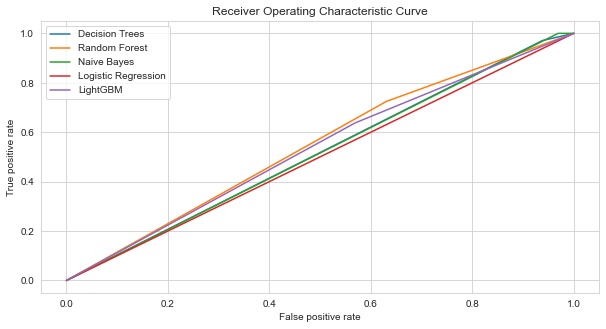

In [18]:
pred=classification.pred(x_train,y_train,x_test,y_test)
classification.roc_curve(pred)

In [19]:
acc_score=classification.show_score(y_test,pred)
model_ev=classification.model_eval(acc_score)
model_ev

--------------Decision Trees---------------------------------------------------------------------
Using the confusion matrix, we have : 
 [[ 4 61]
 [ 2 67]]


The accuracy score of Decision Trees is:
 52.98507462686567


We present the classification report with all the metrics related to the predictive score
              precision    recall  f1-score   support

          -1       0.67      0.06      0.11        65
           1       0.52      0.97      0.68        69

    accuracy                           0.53       134
   macro avg       0.60      0.52      0.40       134
weighted avg       0.59      0.53      0.40       134

****************************************


--------------Random Forest---------------------------------------------------------------------
Using the confusion matrix, we have : 
 [[24 41]
 [19 50]]


The accuracy score of Random Forest is:
 55.223880597014926


We present the classification report with all the metrics related to the predictive score
         

,Model,Accuracy
0,Decision Trees,52.985075
1,Random Forest,55.223881
2,Naive Bayes,52.985075
3,Logistic Regression,51.492537
4,LightGBM,53.731343
